In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
from glob import glob
import skimage.io as io
import shutil

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\unet\sessile-main-Kvasir-SEG


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG"
print(os.listdir(data_dir))

['masks', 'images']


In [5]:
img_dir = data_dir + "/images"
msk_dir = data_dir + "/masks"

print(f"No. Img: {len(os.listdir(img_dir))}")
print(f"No. Msk: {len(os.listdir(msk_dir))}")

No. Img: 196
No. Msk: 196


In [6]:
class PolypDataset(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(img_dir + "/*"))
        self.msks = sorted(glob(msk_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

def mask_to_tensor(mask):
    # threshold = 0  # Ngưỡng để chuyển đổi
    # mask = mask.clone().detach()  # Chuyển mask thành tensor PyTorch
    # mask = (mask > threshold).float()  # Chuyển đổi thành tensor float với giá trị 0 và 1
    # return mask
    threshold = 1
    mask[mask < threshold] = 0
    mask[mask >= threshold] = 1
    return mask.float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


157


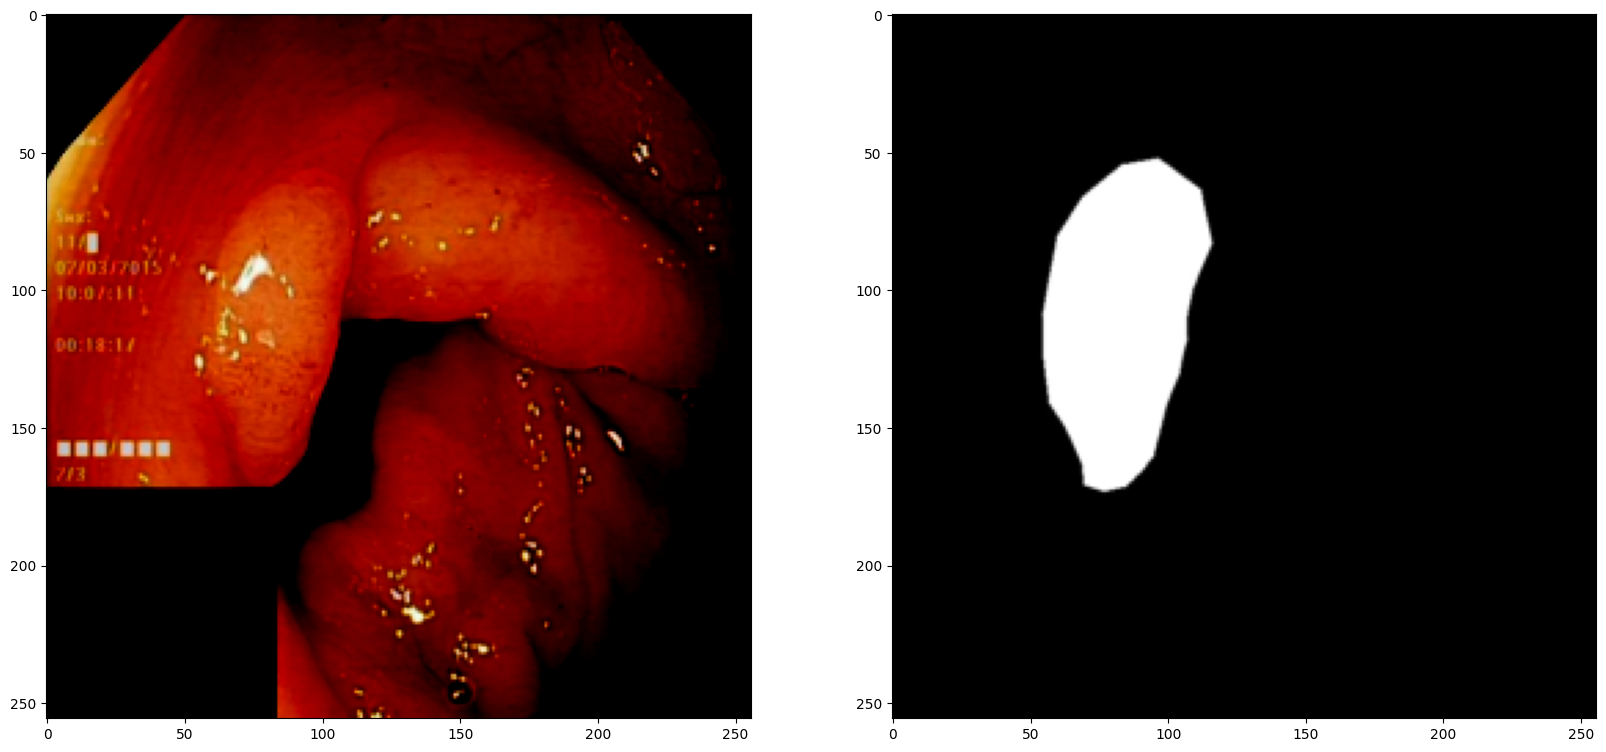

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)), #(1, 256, 256) # (20, 1, 256, 256) (B, C, H, W)
    transforms.ToTensor(),
    # mask_to_tensor
])

ds = PolypDataset(transform=transform, target_transform=target_transform)
train_ds, test_ds = random_split(ds, [0.8, 0.2])

print(len(train_ds))

img, msk = train_ds[30]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
msk.unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1059,
        0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373, 0.1412,
        0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725, 0.1765, 0.1804,
        0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078, 0.2118, 0.2157, 0.2235,
        0.2275, 0.2353, 0.2392, 0.2510, 0.2549, 0.2588, 0.2667, 0.2706, 0.2745,
        0.2784, 0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098,
        0.3137, 0.3216, 0.3255, 0.3294, 0.3412, 0.3451, 0.3490, 0.3529, 0.3569,
        0.3608, 0.3686, 0.3765, 0.3804, 0.3843, 0.3882, 0.3922, 0.3961, 0.4039,
        0.4118, 0.4157, 0.4196, 0.4353, 0.4392, 0.4431, 0.4471, 0.4549, 0.4627,
        0.4667, 0.4706, 0.4824, 0.4902, 0.4980, 0.5020, 0.5059, 0.5137, 0.5176,
        0.5216, 0.5255, 0.5294, 0.5412, 

In [9]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

print(len(train_dl))

3


In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [11]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [12]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [13]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.act = nn.ReLU()

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
def miou(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = torch.argmax(mask, dim=1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, 1, 16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

loss_fn = nn.MSELoss()

In [17]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)
        train_iou = miou(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()       

        scheduler.step()
        
        tr_total_loss += train_loss.cpu().item()        
        tr_total_iou += train_iou.item()
        
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_train_iou_score = tr_total_iou/len(train_dl)
    print(f"Epoch: {epoch} - IouScore: {mean_train_iou_score}")

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
    
model.load_state_dict(best_dct)

100%|████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch: 0 - IouScore: 1.0
Epoch: 0 - TrainLoss: 0.13868317008018494


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch: 1 - IouScore: 1.0
Epoch: 1 - TrainLoss: 0.0757832204302152


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch: 2 - IouScore: 1.0
Epoch: 2 - TrainLoss: 0.07025591532389323


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch: 3 - IouScore: 1.0
Epoch: 3 - TrainLoss: 0.0666839766005675


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch: 4 - IouScore: 1.0
Epoch: 4 - TrainLoss: 0.0697773906091849


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch: 5 - IouScore: 1.0
Epoch: 5 - TrainLoss: 0.06377338245511055


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 6 - IouScore: 1.0
Epoch: 6 - TrainLoss: 0.06408499057094257


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch: 7 - IouScore: 1.0
Epoch: 7 - TrainLoss: 0.06290154904127121


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 8 - IouScore: 1.0
Epoch: 8 - TrainLoss: 0.06550688296556473


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Epoch: 9 - IouScore: 1.0
Epoch: 9 - TrainLoss: 0.06179141625761986


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 10 - IouScore: 1.0
Epoch: 10 - TrainLoss: 0.06711693728963534


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch: 11 - IouScore: 1.0
Epoch: 11 - TrainLoss: 0.0623171292245388


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch: 12 - IouScore: 1.0
Epoch: 12 - TrainLoss: 0.06446858247121175


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 13 - IouScore: 1.0
Epoch: 13 - TrainLoss: 0.06032312040527662


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch: 14 - IouScore: 1.0
Epoch: 14 - TrainLoss: 0.06710206220547359


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch: 15 - IouScore: 1.0
Epoch: 15 - TrainLoss: 0.061661978562672935


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 16 - IouScore: 1.0
Epoch: 16 - TrainLoss: 0.05986263106266657


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch: 17 - IouScore: 1.0
Epoch: 17 - TrainLoss: 0.05970577150583267


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 18 - IouScore: 1.0
Epoch: 18 - TrainLoss: 0.05697605634729067


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch: 19 - IouScore: 1.0
Epoch: 19 - TrainLoss: 0.05683050553003947


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch: 20 - IouScore: 1.0
Epoch: 20 - TrainLoss: 0.055399488657712936


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch: 21 - IouScore: 1.0
Epoch: 21 - TrainLoss: 0.055442821234464645


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch: 22 - IouScore: 1.0
Epoch: 22 - TrainLoss: 0.055848525216182075


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 23 - IouScore: 1.0
Epoch: 23 - TrainLoss: 0.05647063131133715


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch: 24 - IouScore: 1.0
Epoch: 24 - TrainLoss: 0.05410295103987058


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch: 25 - IouScore: 1.0
Epoch: 25 - TrainLoss: 0.05170398826400439


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 26 - IouScore: 1.0
Epoch: 26 - TrainLoss: 0.04873128980398178


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Epoch: 27 - IouScore: 1.0
Epoch: 27 - TrainLoss: 0.048355688651402794


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Epoch: 28 - IouScore: 1.0
Epoch: 28 - TrainLoss: 0.04984525963664055


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 29 - IouScore: 1.0
Epoch: 29 - TrainLoss: 0.04804769530892372


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch: 30 - IouScore: 1.0
Epoch: 30 - TrainLoss: 0.0468452051281929


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 31 - IouScore: 1.0
Epoch: 31 - TrainLoss: 0.04400377720594406


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch: 32 - IouScore: 1.0
Epoch: 32 - TrainLoss: 0.04398364697893461


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch: 33 - IouScore: 1.0
Epoch: 33 - TrainLoss: 0.043505764255921044


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch: 34 - IouScore: 1.0
Epoch: 34 - TrainLoss: 0.04300652196009954


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch: 35 - IouScore: 1.0
Epoch: 35 - TrainLoss: 0.03950351352492968


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 36 - IouScore: 1.0
Epoch: 36 - TrainLoss: 0.03664895022908846


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch: 37 - IouScore: 1.0
Epoch: 37 - TrainLoss: 0.03656366840004921


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch: 38 - IouScore: 1.0
Epoch: 38 - TrainLoss: 0.031904395048817


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 39 - IouScore: 1.0
Epoch: 39 - TrainLoss: 0.03474301161865393


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Epoch: 40 - IouScore: 1.0
Epoch: 40 - TrainLoss: 0.03274094499647617


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch: 41 - IouScore: 1.0
Epoch: 41 - TrainLoss: 0.03600134948889414


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 42 - IouScore: 1.0
Epoch: 42 - TrainLoss: 0.030755536009867985


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch: 43 - IouScore: 1.0
Epoch: 43 - TrainLoss: 0.026458826536933582


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 44 - IouScore: 1.0
Epoch: 44 - TrainLoss: 0.02700527012348175


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 45 - IouScore: 1.0
Epoch: 45 - TrainLoss: 0.02664957381784916


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch: 46 - IouScore: 1.0
Epoch: 46 - TrainLoss: 0.02581591159105301


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 47 - IouScore: 1.0
Epoch: 47 - TrainLoss: 0.024021667738755543


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch: 48 - IouScore: 1.0
Epoch: 48 - TrainLoss: 0.02185545489192009


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Epoch: 49 - IouScore: 1.0
Epoch: 49 - TrainLoss: 0.019104852030674618


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 50 - IouScore: 1.0
Epoch: 50 - TrainLoss: 0.02022407886882623


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch: 51 - IouScore: 1.0
Epoch: 51 - TrainLoss: 0.018496731917063396


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Epoch: 52 - IouScore: 1.0
Epoch: 52 - TrainLoss: 0.01831279539813598


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch: 53 - IouScore: 1.0
Epoch: 53 - TrainLoss: 0.016992139940460522


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch: 54 - IouScore: 1.0
Epoch: 54 - TrainLoss: 0.015754292408625286


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 55 - IouScore: 1.0
Epoch: 55 - TrainLoss: 0.016009742704530556


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch: 56 - IouScore: 1.0
Epoch: 56 - TrainLoss: 0.013779269841810068


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 57 - IouScore: 1.0
Epoch: 57 - TrainLoss: 0.01383983219663302


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 58 - IouScore: 1.0
Epoch: 58 - TrainLoss: 0.012516281257073084


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch: 59 - IouScore: 1.0
Epoch: 59 - TrainLoss: 0.010702724878986677


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 60 - IouScore: 1.0
Epoch: 60 - TrainLoss: 0.010706040387352308


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch: 61 - IouScore: 1.0
Epoch: 61 - TrainLoss: 0.010540473585327467


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch: 62 - IouScore: 1.0
Epoch: 62 - TrainLoss: 0.010354922463496527


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch: 63 - IouScore: 1.0
Epoch: 63 - TrainLoss: 0.009486335019270578


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch: 64 - IouScore: 1.0
Epoch: 64 - TrainLoss: 0.011190897474686304


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Epoch: 65 - IouScore: 1.0
Epoch: 65 - TrainLoss: 0.00998278334736824


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch: 66 - IouScore: 1.0
Epoch: 66 - TrainLoss: 0.009153122082352638


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch: 67 - IouScore: 1.0
Epoch: 67 - TrainLoss: 0.00968534623583158


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch: 68 - IouScore: 1.0
Epoch: 68 - TrainLoss: 0.009345754670600096


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch: 69 - IouScore: 1.0
Epoch: 69 - TrainLoss: 0.009548311121761799


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch: 70 - IouScore: 1.0
Epoch: 70 - TrainLoss: 0.008510108726720015


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 71 - IouScore: 1.0
Epoch: 71 - TrainLoss: 0.009361456769208113


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch: 72 - IouScore: 1.0
Epoch: 72 - TrainLoss: 0.008272874169051647


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch: 73 - IouScore: 1.0
Epoch: 73 - TrainLoss: 0.00903146838148435


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 74 - IouScore: 1.0
Epoch: 74 - TrainLoss: 0.007382154619942109


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Epoch: 75 - IouScore: 1.0
Epoch: 75 - TrainLoss: 0.00756507134065032


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Epoch: 76 - IouScore: 1.0
Epoch: 76 - TrainLoss: 0.010787410972019037


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 77 - IouScore: 1.0
Epoch: 77 - TrainLoss: 0.007891364395618439


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Epoch: 78 - IouScore: 1.0
Epoch: 78 - TrainLoss: 0.007444213144481182


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 79 - IouScore: 1.0
Epoch: 79 - TrainLoss: 0.007956429074207941


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 80 - IouScore: 1.0
Epoch: 80 - TrainLoss: 0.0068430714309215546


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch: 81 - IouScore: 1.0
Epoch: 81 - TrainLoss: 0.007079900087167819


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 82 - IouScore: 1.0
Epoch: 82 - TrainLoss: 0.0073894768332441645


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch: 83 - IouScore: 1.0
Epoch: 83 - TrainLoss: 0.006060886972894271


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 84 - IouScore: 1.0
Epoch: 84 - TrainLoss: 0.006170584975431363


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch: 85 - IouScore: 1.0
Epoch: 85 - TrainLoss: 0.005929187871515751


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch: 86 - IouScore: 1.0
Epoch: 86 - TrainLoss: 0.007791606554140647


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 87 - IouScore: 1.0
Epoch: 87 - TrainLoss: 0.006918989742795627


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Epoch: 88 - IouScore: 1.0
Epoch: 88 - TrainLoss: 0.006934078875929117


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 89 - IouScore: 1.0
Epoch: 89 - TrainLoss: 0.005503943966080745


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch: 90 - IouScore: 1.0
Epoch: 90 - TrainLoss: 0.006978744951387246


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch: 91 - IouScore: 1.0
Epoch: 91 - TrainLoss: 0.005202160527308782


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch: 92 - IouScore: 1.0
Epoch: 92 - TrainLoss: 0.005589677797009547


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch: 93 - IouScore: 1.0
Epoch: 93 - TrainLoss: 0.006774587091058493


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 94 - IouScore: 1.0
Epoch: 94 - TrainLoss: 0.005081519950181246


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch: 95 - IouScore: 1.0
Epoch: 95 - TrainLoss: 0.005676864801595609


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 96 - IouScore: 1.0
Epoch: 96 - TrainLoss: 0.006755814577142398


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch: 97 - IouScore: 1.0
Epoch: 97 - TrainLoss: 0.006094288236151139


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch: 98 - IouScore: 1.0
Epoch: 98 - TrainLoss: 0.0051679898363848524


100%|████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]

Epoch: 99 - IouScore: 1.0
Epoch: 99 - TrainLoss: 0.005119719232122104


<All keys matched successfully>

In [18]:
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
print(len(test_dl))

39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


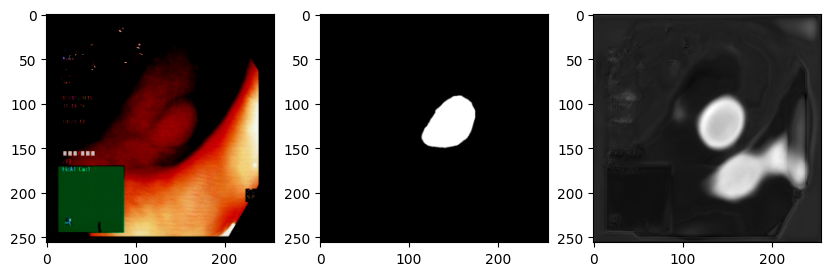

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


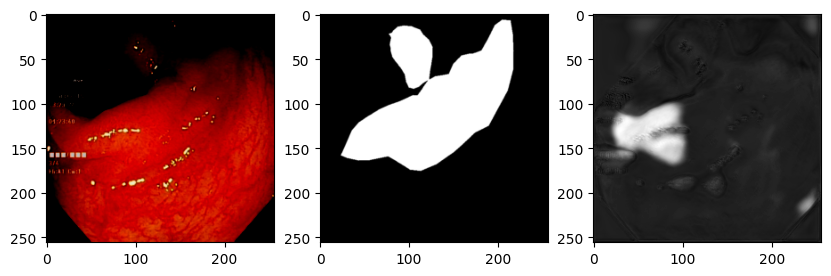

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


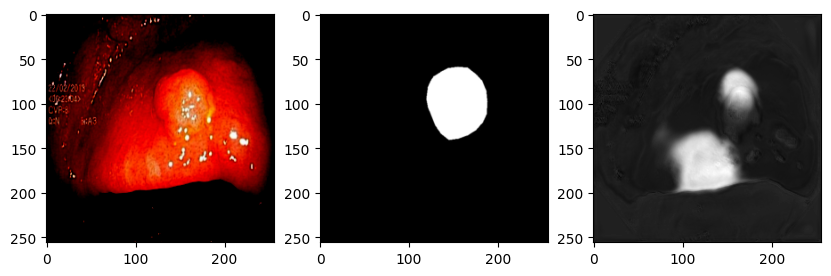

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


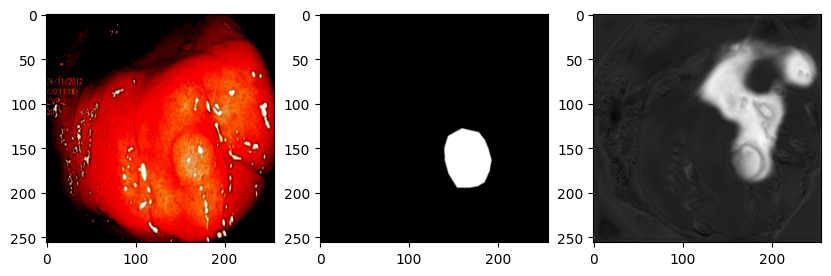

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


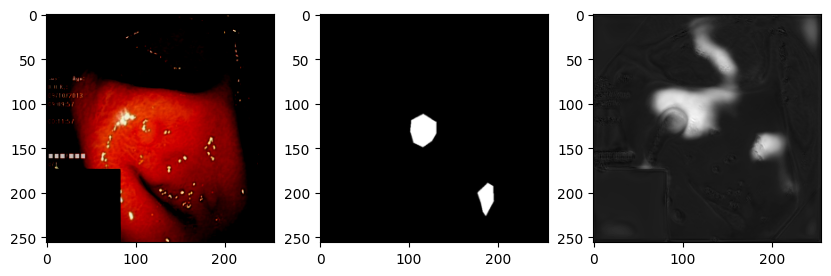

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


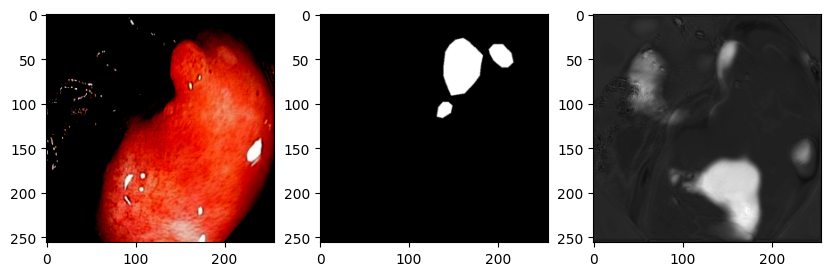

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


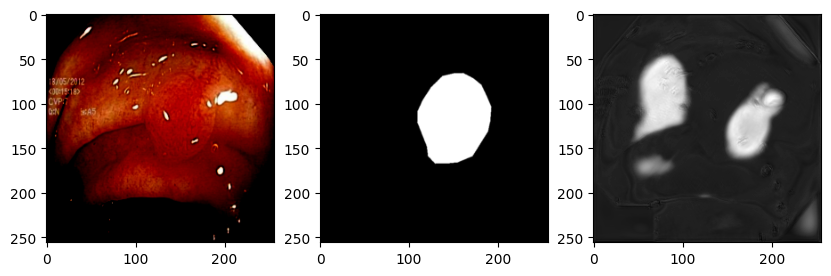

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


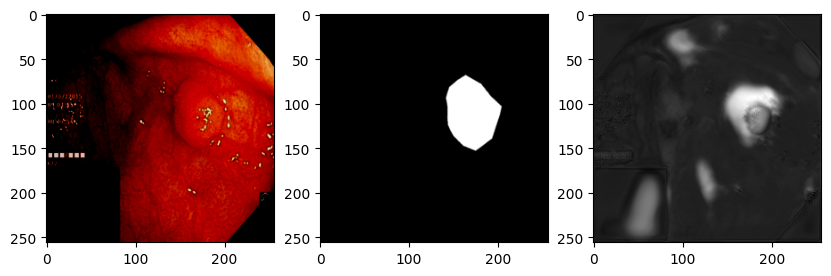

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


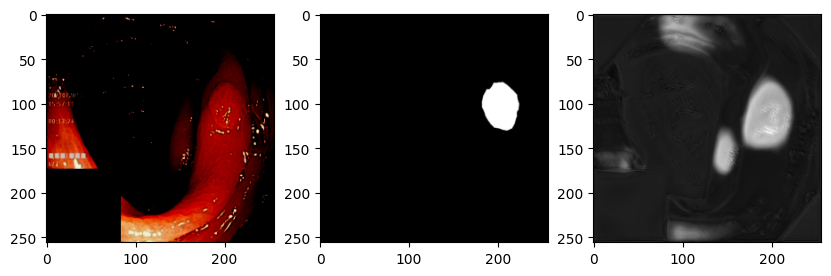

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


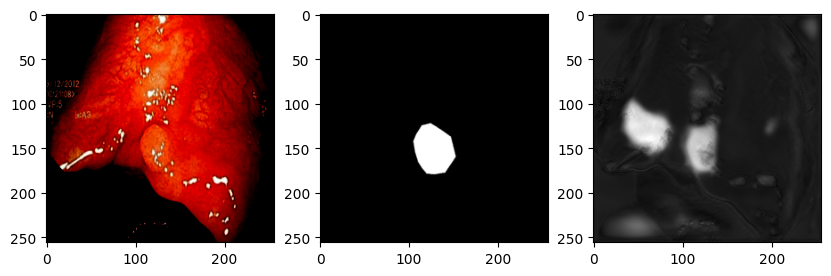

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


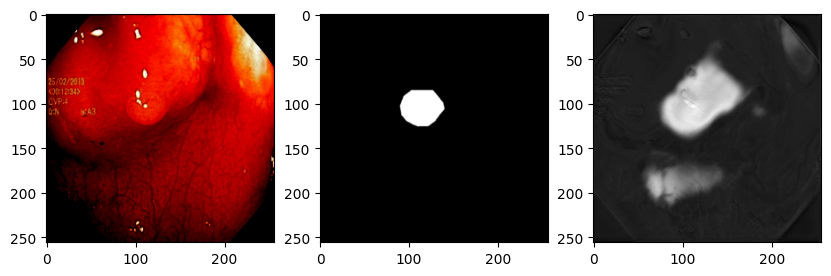

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


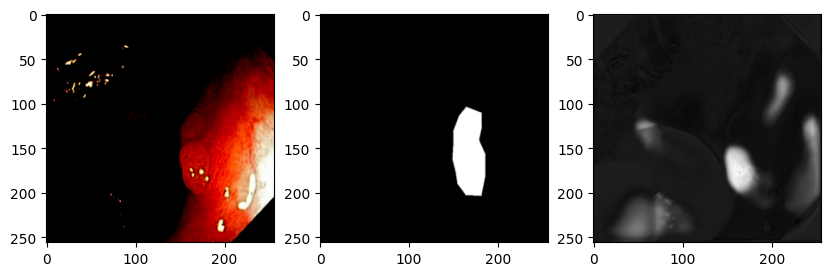

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


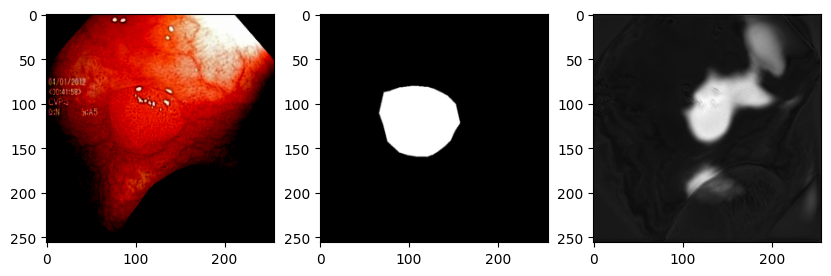

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


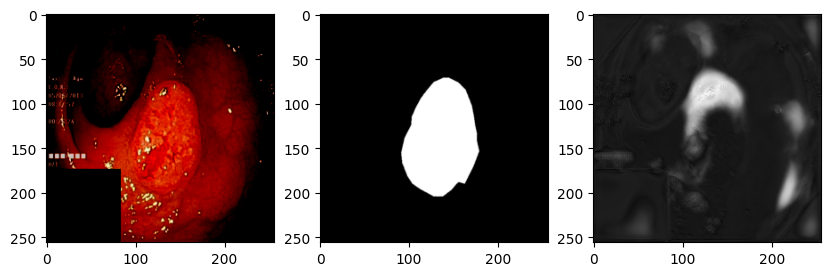

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


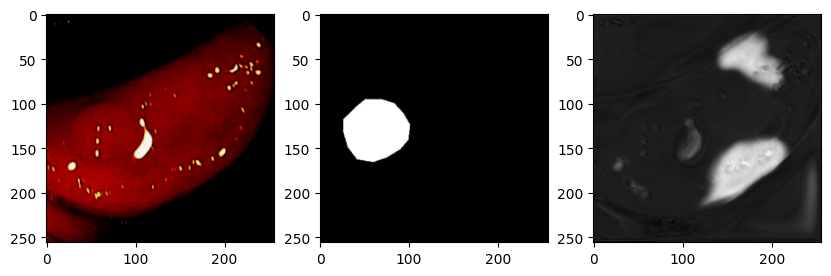

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


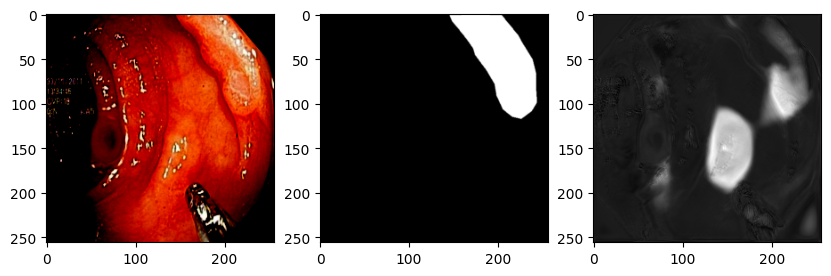

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


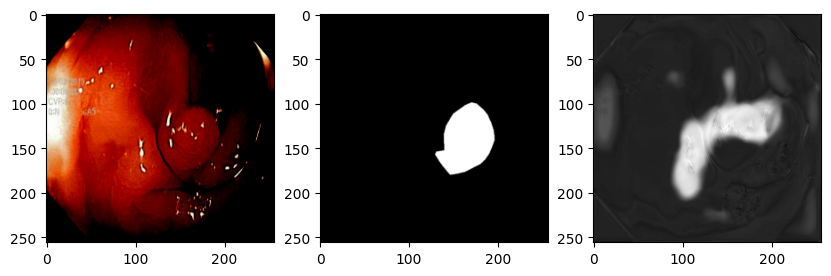

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


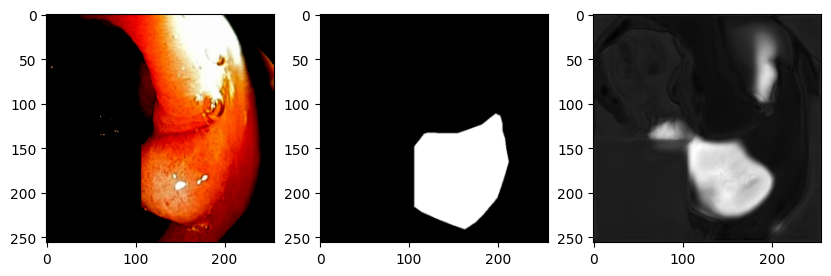

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


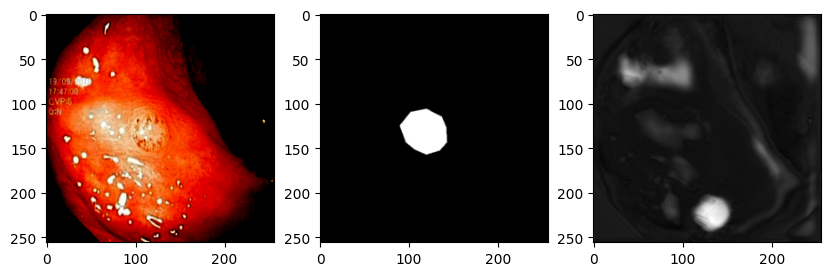

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


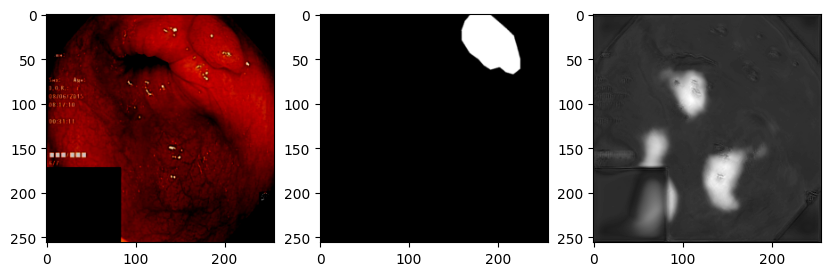

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


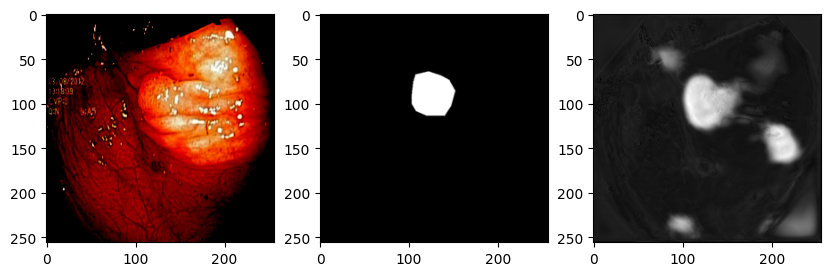

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


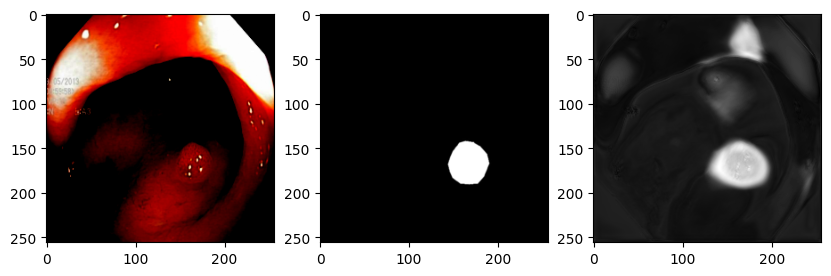

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


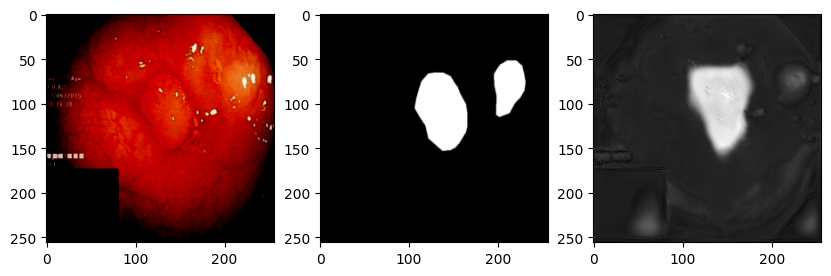

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


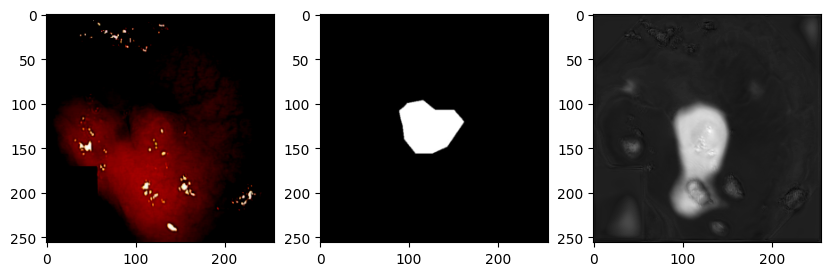

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


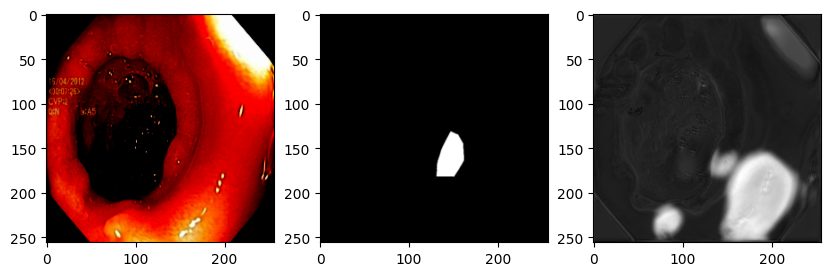

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


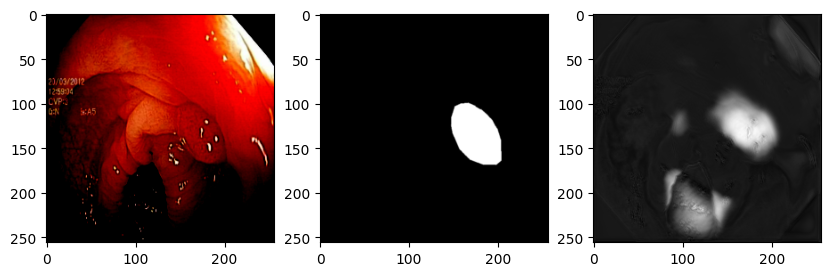

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


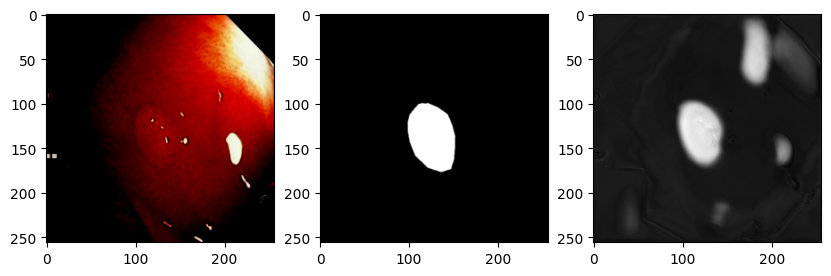

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


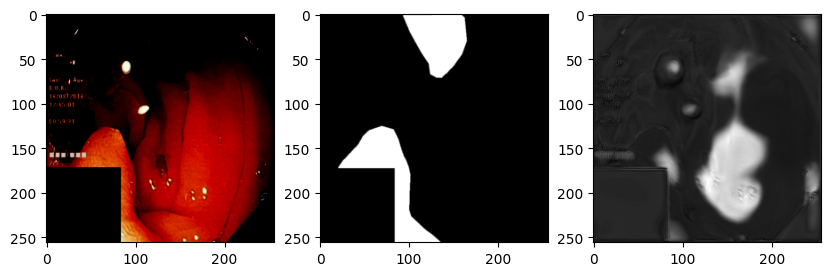

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


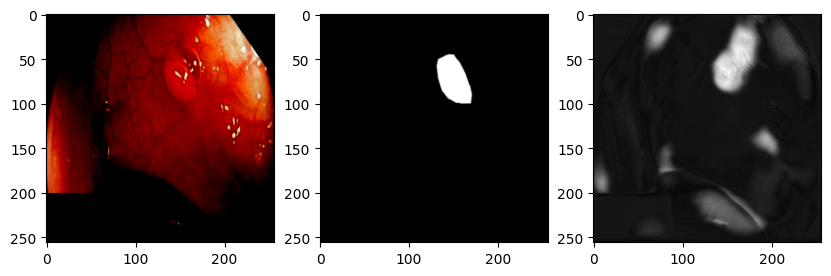

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


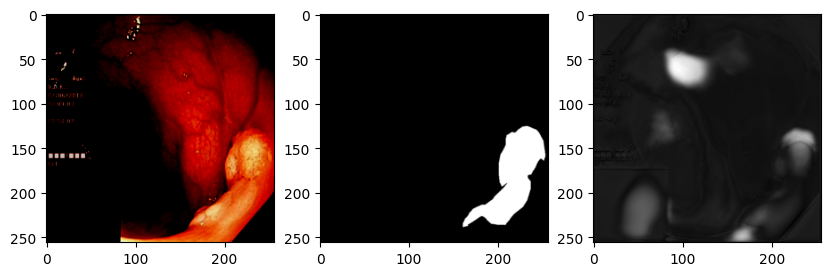

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


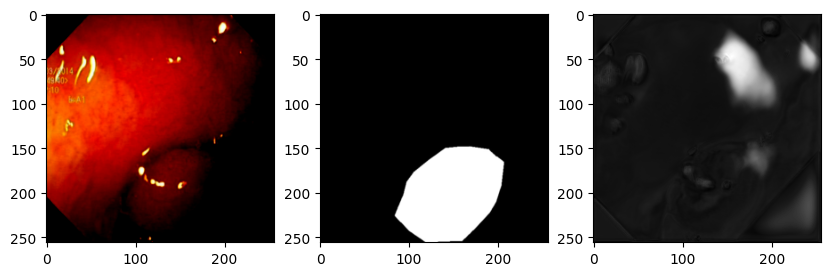

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


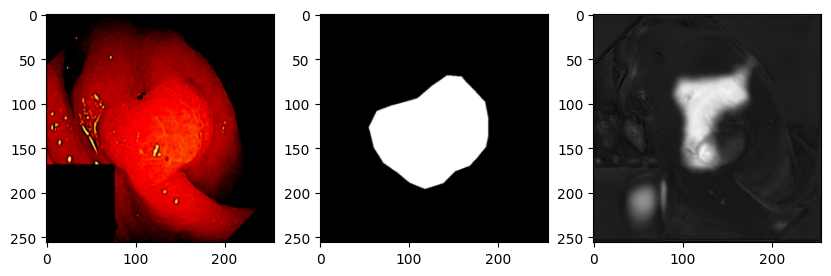

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


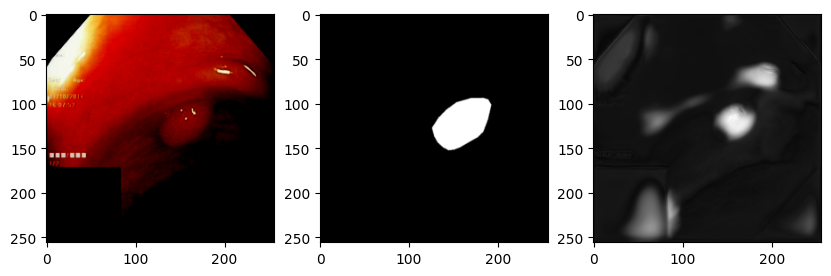

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


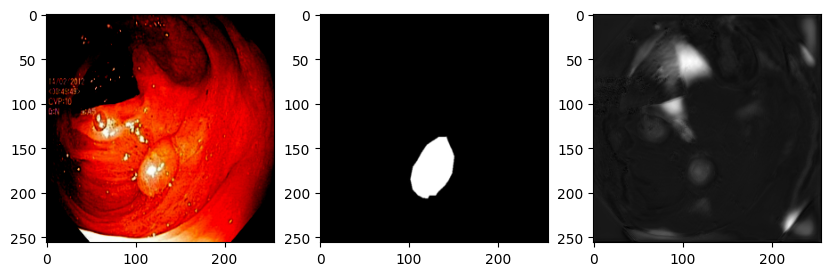

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


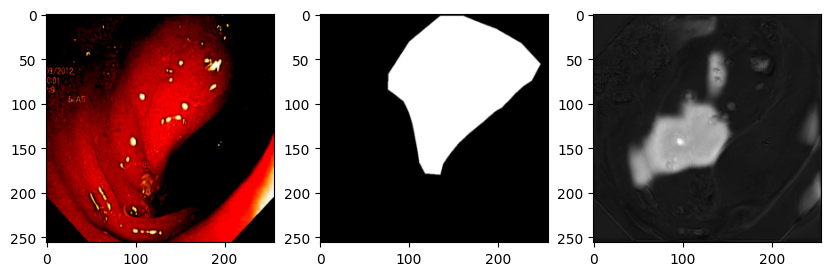

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


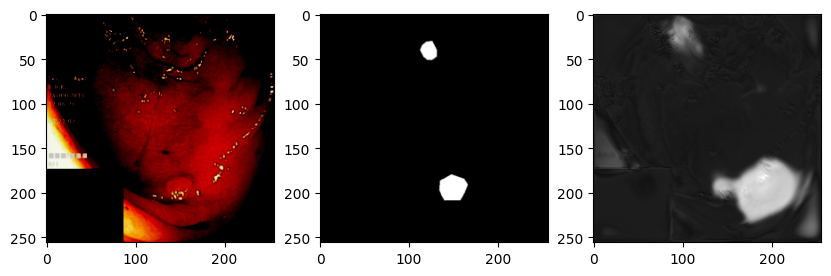

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


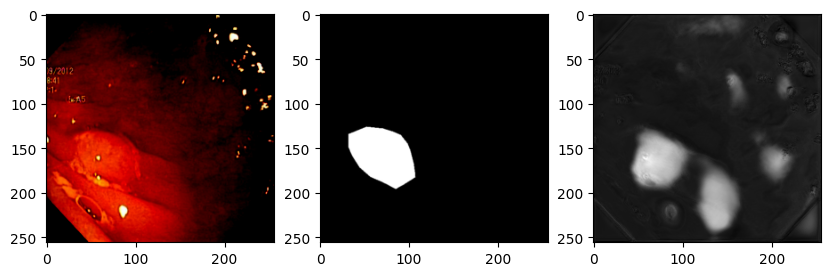

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


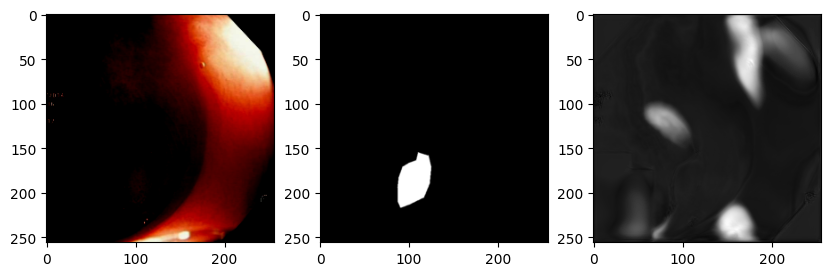

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


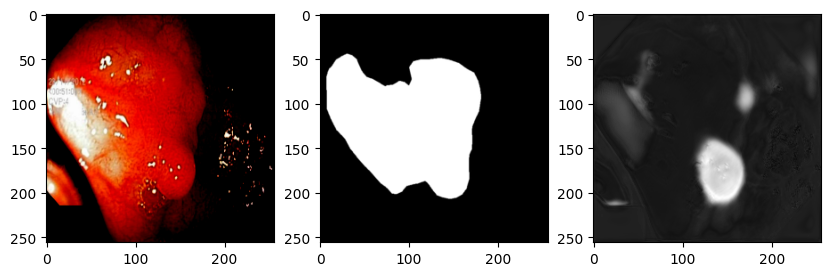

In [19]:
from glob import glob
for img, mask in test_dl:
    img = img.to(device)
    masks = mask.to(device)
    

    mask = model(img)
    # Giả sử ngưỡng của bạn là 0.5 (có thể thay đổi theo yêu cầu của bạn)
#     threshold = 0.5

# # Áp dụng ngưỡng vào mask
#     binary_mask = (mask > threshold).float()
    binary_mask = mask
 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(masks[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
    ax3.imshow(binary_mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()  
    plt.close("all")  

In [20]:
binary_mask.unique()

tensor([-0.1455, -0.1103, -0.1002,  ...,  1.4815,  1.4820,  1.4821],
       device='cuda:1', grad_fn=<Unique2Backward0>)

In [21]:
binary_mask.shape

torch.Size([1, 1, 256, 256])